In [1]:
!pip install s3fs

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.28.5 requires faiss-cpu!=1.8.0.post0,<2.0.0,>=1.8.0, which is not installed.
jupyter-scheduler 2.9.0 requires fsspec==2023.6.0, but you have fsspec 2025.2.0 which is incompatible.


In [2]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.2/540.2 kB 15.0 MB/s eta 0:00:00


In [3]:
!pip install smdebug

  Preparing metadata (setup.py) ... done
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl size=6443 sha256=a93fded899df2ea41d3b193957b2b053b0e491acdd7115aa08465a8beaa9185c
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/6c/d4/b3/f7bd451cdb774b086ee5c4791eff9a667fb197759f2f691f66
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [4]:
!pip install smdebug

In [7]:
import re
import s3fs
import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

sagemaker.config INFO - Fetched defaults config from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
[2025-02-18 04:53:56.156 default:3100 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [8]:
default_bucket = "julia-ohio-bucket1"

In [9]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix


In [10]:
def preprocess_data(file_path):
    df = pd.read_excel(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df

In [11]:
!pip install openpyxl

In [12]:
storedata = preprocess_data(f"s3://{default_bucket}/data/storedata_total.xlsx")


In [13]:
storedata.head(5)

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,True,False,False,False,False,False,False,True,False,False


In [14]:
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names, train, validation, test

In [15]:
feature_names, train, validation, test = split_datasets(storedata)


In [16]:
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/data/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/data/validate/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/data/test/test.csv",header=False,index=False)

In [17]:
train_input = TrainingInput(
    "s3://{}/{}/{}".format(default_bucket, "data", "train/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(default_bucket, "data", "validate/validation.csv"), content_type="csv"
)

In [18]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [19]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.Subnets
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.SecurityGroupIds


In [20]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [21]:
objective_metric_name = "validation:auc"

In [22]:
tuner = HyperparameterTuner(
    estimator, objective_metric_name, hyperparameter_ranges, max_jobs=10, max_parallel_jobs=2)

In [25]:
tuner.fit({
    "train":train_input,
    "validation":validation_input
    },include_cls_metadata=False)

................................................................!


In [26]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

In [27]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


In [28]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2025, 2, 18, 5, 18, 42, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9819520115852356},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2025, 2, 18, 5, 19, 15, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:739275442502:training-job/sagemaker-xgboost-250218-0513-010-7e309080',
 'TrainingJobName': 'sagemaker-xgboost-250218-0513-010-7e309080',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2025, 2, 18, 5, 18, 46, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.9461710205179219',
                          'eta': '0.06380472551698524',
                          'max_depth': '7',
                          'min_child_weight': '1.0872227881975918'}}


In [29]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [30]:
best_hyperparameters

{'alpha': '0.9461710205179219',
 'eta': '0.06380472551698524',
 'max_depth': '7',
 'min_child_weight': '1.0872227881975918'}

In [31]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [32]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

In [33]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.Subnets
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.SecurityGroupIds


In [36]:
estimator.fit(
        {"train":train_input,"validation":validation_input},wait=False
    )

In [37]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: Completed, Rule Evaluation Status: InProgress


In [38]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:739275442502:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-c2ac7587',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2025, 2, 18, 5, 31, 30, 498000, tzinfo=tzlocal())}]

In [39]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2025-02-18 05:31:51.578 default:3100 INFO s3_trial.py:42] Loading trial debug-output at path s3://julia-ohio-bucket1/debugger/demo-smdebug-xgboost-churn-classificati-2025-02-18-05-27-02-859/debug-output


In [40]:
trial.tensor_names()

[2025-02-18 05:31:56.705 default:3100 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-02-18 05:31:57.723 default:3100 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [41]:
trial.tensor("average_shap/f1").values()

{0: array([0.00035143], dtype=float32),
 5: array([0.00280313], dtype=float32),
 10: array([0.00562153], dtype=float32),
 15: array([0.00702232], dtype=float32),
 20: array([0.00952355], dtype=float32),
 25: array([0.01456784], dtype=float32),
 30: array([0.02095415], dtype=float32),
 35: array([0.0248091], dtype=float32),
 40: array([0.03084199], dtype=float32),
 45: array([0.04040762], dtype=float32),
 50: array([0.04639203], dtype=float32),
 55: array([0.05316806], dtype=float32),
 60: array([0.06054043], dtype=float32),
 65: array([0.07156266], dtype=float32),
 70: array([0.07859238], dtype=float32),
 75: array([0.08579968], dtype=float32),
 80: array([0.09633423], dtype=float32),
 85: array([0.10564032], dtype=float32),
 90: array([0.11402911], dtype=float32),
 95: array([0.12334755], dtype=float32)}

In [42]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

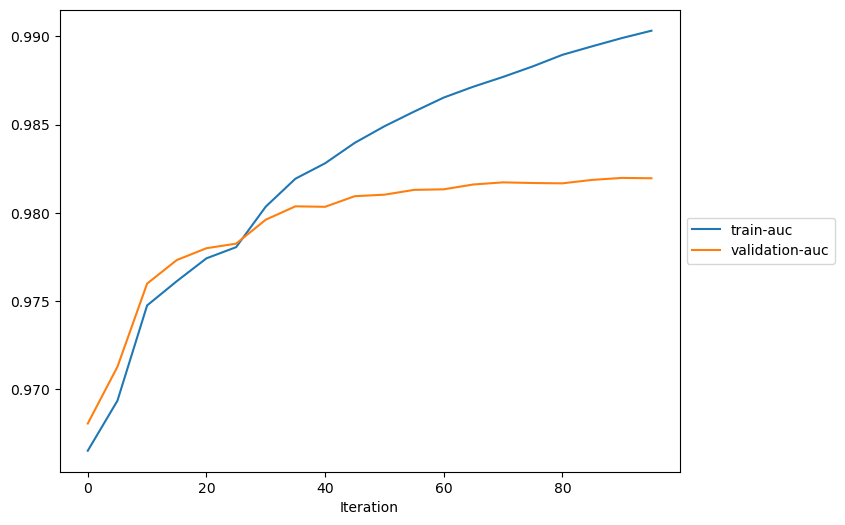

In [43]:
plot_collection(trial, "metrics")

In [44]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

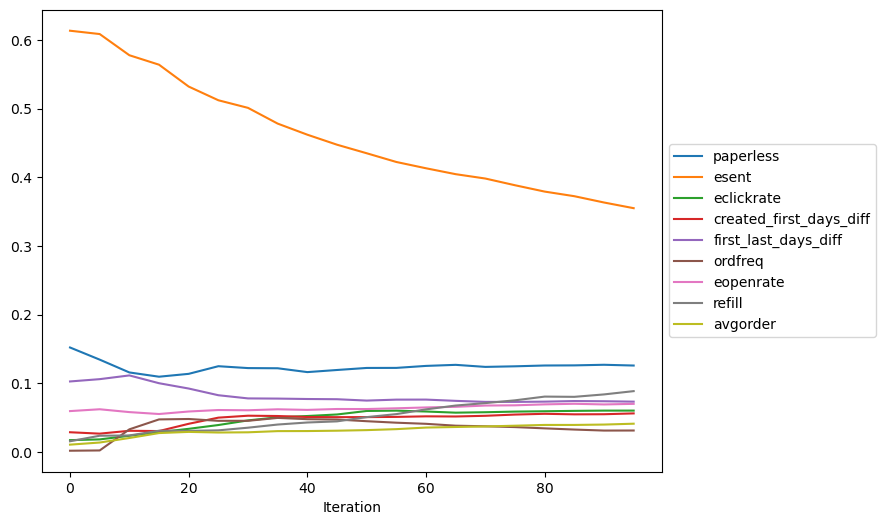

In [45]:
plot_feature_importance(trial, importance_type="cover")

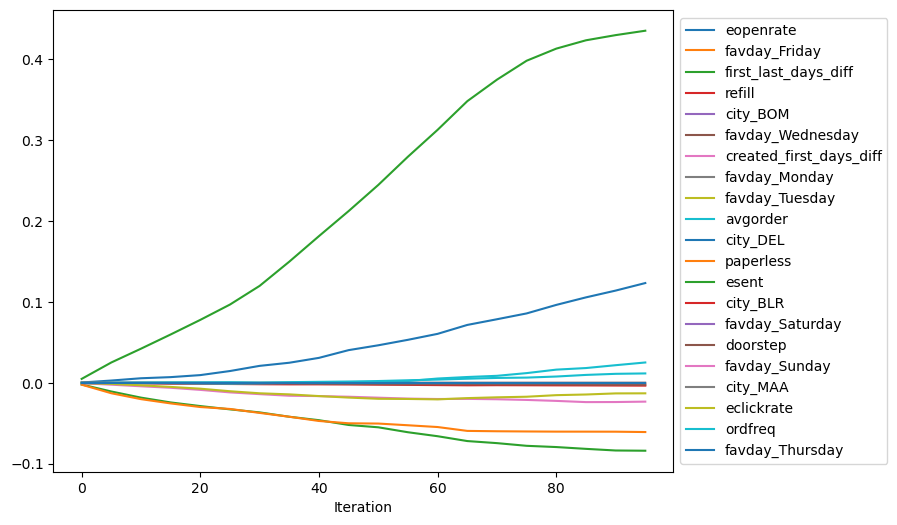

In [46]:
plot_collection(trial, "average_shap")

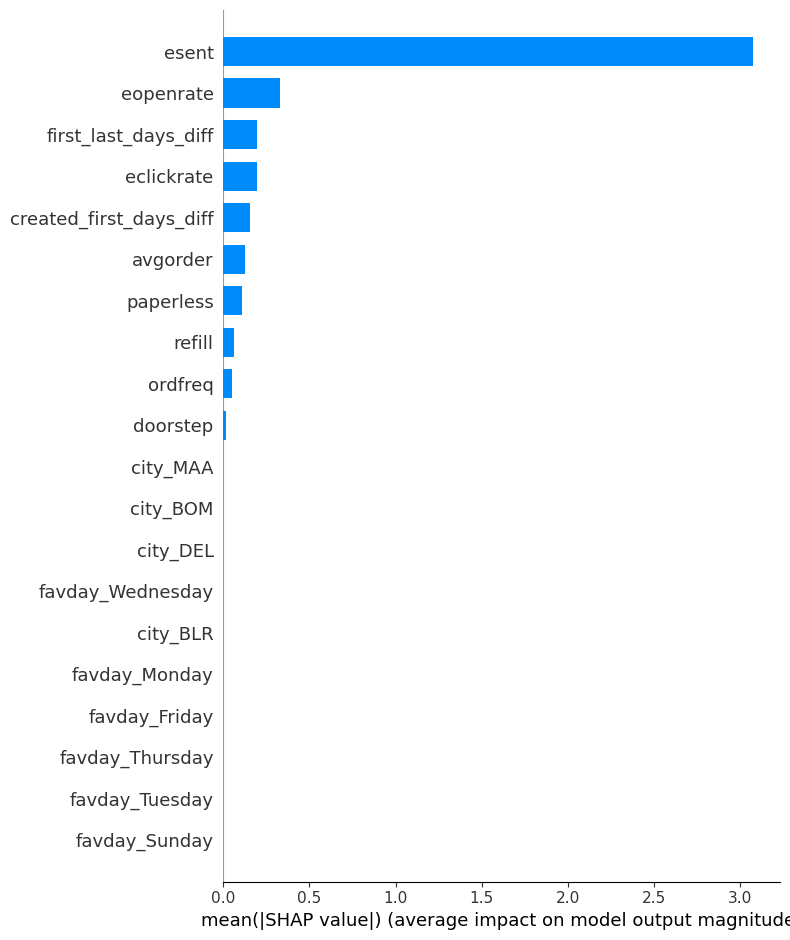

In [47]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [48]:
shap_base_value

2.0867467

In [49]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

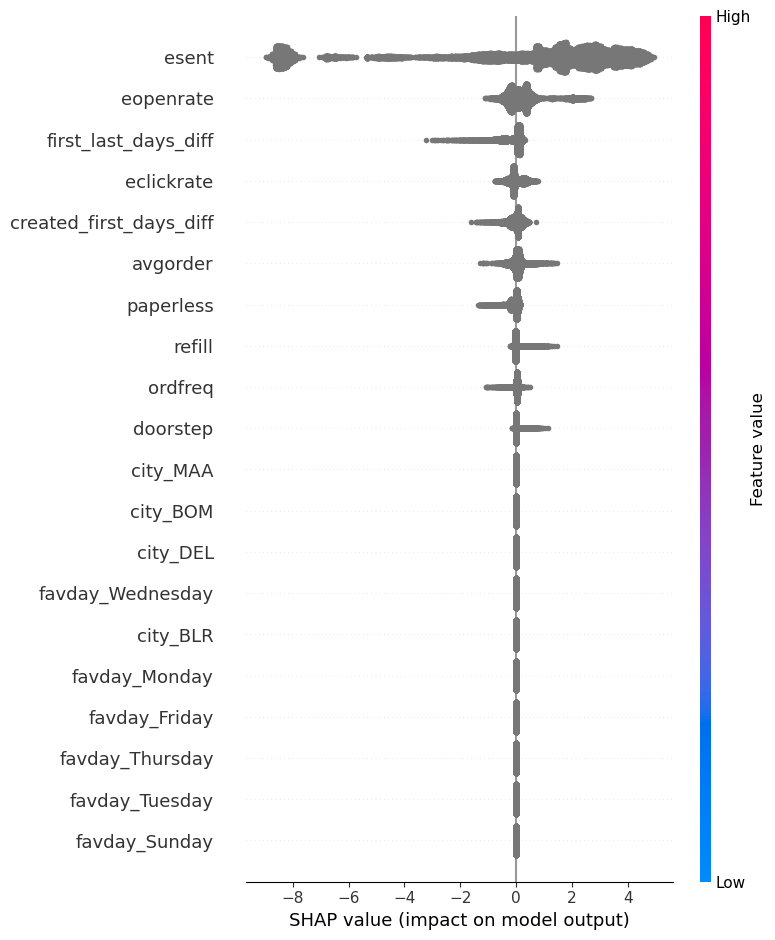

In [50]:
shap.summary_plot(shap_no_base, train_shap)

In [51]:
shap.initjs()

In [52]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [53]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [54]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)